<a href="https://colab.research.google.com/github/telnarayanan/HuggingFaceTransformers/blob/main/ViT_Xray_BiTs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Getting Setup



In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.12.1+cu113
torchvision version: 0.13.1+cu113


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3097, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 3097 (delta 11), reused 26 (delta 7), pack-reused 3067
Receiving objects: 100% (3097/3097), 639.02 MiB | 17.24 MiB/s, done.
Resolving deltas: 100% (1763/1763), done.
Checking out files: 100% (218/218), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Get Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Verify Data
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

In [6]:
from os import walk
for (dirpath, dirnames, filenames) in walk("/content/drive/My Drive/Data/XRay/"):
    print("Directory path: ", dirpath)
    print("Folder name: ", dirnames)
    print("File name: ", filenames)

Directory path:  /content/drive/My Drive/Data/XRay/
Folder name:  ['XRayExtract']
File name:  ['Train_Test_Image.zip']
Directory path:  /content/drive/My Drive/Data/XRay/XRayExtract
Folder name:  ['Test', 'Train']
File name:  []
Directory path:  /content/drive/My Drive/Data/XRay/XRayExtract/Test
Folder name:  ['COVID', 'non_COVID']
File name:  []
Directory path:  /content/drive/My Drive/Data/XRay/XRayExtract/Test/COVID
Folder name:  []
File name:  ['COVID19(396).jpg', 'COVID19(410).jpg', 'COVID19(285).jpg', 'COVID19(337).jpg', 'COVID19(442).jpg', 'COVID19(164).jpg', 'COVID19(183).jpg', 'COVID-19 (745).jpg', 'COVID-19 (831).jpg', 'COVID-19 (865).jpg', 'COVID-19 (773).jpg', 'COVID19(463).jpg', 'COVID19(287).jpg', 'COVID19(419).jpg', 'COVID19(106).jpg', 'COVID-19 (709).jpg', 'COVID19(415).jpg', 'COVID19(499).jpg', 'COVID19(153).jpg', 'COVID19(63).jpg', 'COVID-19 (750).jpg', 'COVID19(210).jpg', 'COVID19(275).jpg', 'COVID19(324).jpg', 'COVID19(8).jpg', 'COVID19(100).jpg', 'COVID19(423).jpg'

In [7]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [8]:
from pathlib import Path

# Setup path to data folder
data_path = Path("/content/drive/My Drive/Data/XRay")
image_path = data_path / "XRayExtract"
walk_through_dir(image_path)

There are 2 directories and 0 images in '/content/drive/My Drive/Data/XRay/XRayExtract'.
There are 2 directories and 0 images in '/content/drive/My Drive/Data/XRay/XRayExtract/Test'.
There are 0 directories and 167 images in '/content/drive/My Drive/Data/XRay/XRayExtract/Test/COVID'.
There are 0 directories and 317 images in '/content/drive/My Drive/Data/XRay/XRayExtract/Test/non_COVID'.
There are 2 directories and 0 images in '/content/drive/My Drive/Data/XRay/XRayExtract/Train'.
There are 0 directories and 543 images in '/content/drive/My Drive/Data/XRay/XRayExtract/Train/COVID'.
There are 0 directories and 1266 images in '/content/drive/My Drive/Data/XRay/XRayExtract/Train/non_COVID'.


In [9]:
# Setup train and testing paths
train_dir = image_path / "Train"
test_dir = image_path / "Test"

train_dir, test_dir

(PosixPath('/content/drive/My Drive/Data/XRay/XRayExtract/Train'),
 PosixPath('/content/drive/My Drive/Data/XRay/XRayExtract/Test'))

# 2. Create Datasets and DataLoaders

In [10]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [11]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f1b5b34db50>,
 ['COVID', 'non_COVID'])

In [12]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

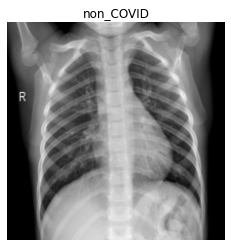

In [13]:

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

# 3. Replicating the ViT paper: an overview

#4. Eq 1: The Patch Embedding

In [14]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [15]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


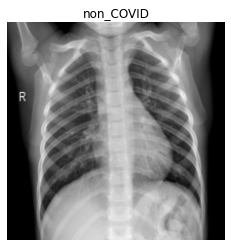

In [16]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

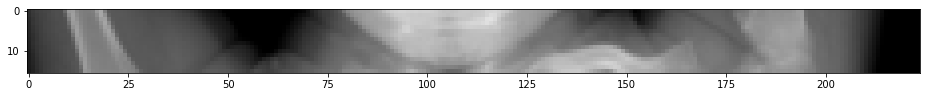

In [17]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels) 
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


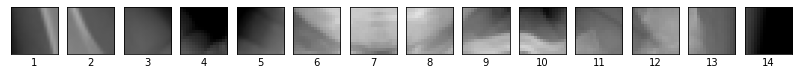

In [18]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


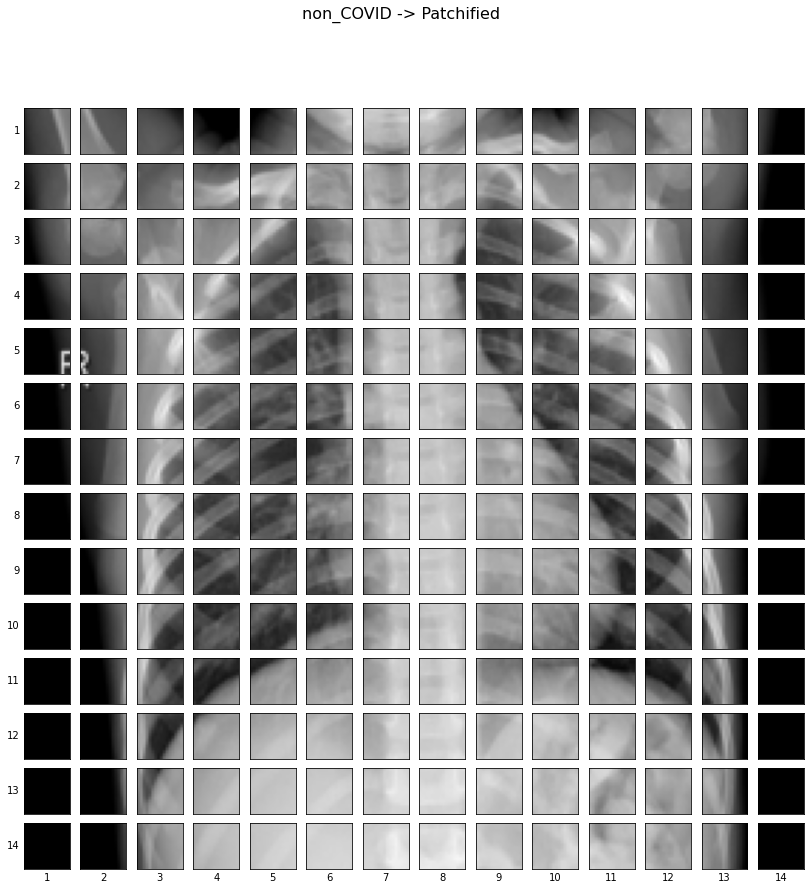

In [19]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height 
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels
        
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [20]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

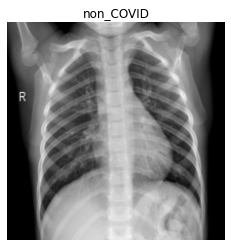

In [21]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [22]:
# Pass the image through the convolutional layer 
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [300, 569, 544, 449, 101]


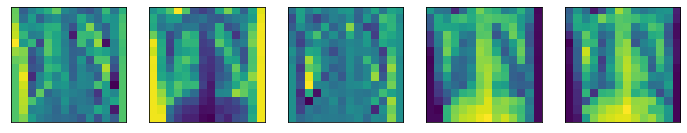

In [23]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [24]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0184,  0.0255,  0.0140, -0.0197,  0.0080, -0.0614, -0.0261,
           -0.0830,  0.0077,  0.0189,  0.0112, -0.0330,  0.0086,  0.0294],
          [ 0.0045, -0.0165,  0.0014,  0.1246,  0.0162, -0.0202, -0.0281,
            0.0108, -0.0506, -0.0440, -0.0301, -0.0707, -0.0031,  0.0275],
          [-0.0112, -0.0312, -0.0329,  0.0035, -0.0560, -0.0170, -0.0465,
           -0.0053, -0.0365, -0.1218, -0.0380, -0.0037, -0.0092,  0.0202],
          [-0.0091, -0.0032, -0.0554, -0.0168, -0.0187,  0.0360, -0.0198,
           -0.0176,  0.0796, -0.0658, -0.0076, -0.0018,  0.0041,  0.0235],
          [ 0.1434, -0.0581, -0.0653,  0.0350, -0.0476,  0.0440, -0.0539,
           -0.0469, -0.0008,  0.0269, -0.0737, -0.0364,  0.0025,  0.0264],
          [ 0.0020,  0.0184, -0.0311, -0.0155, -0.0280,  0.0018, -0.0476,
           -0.0314, -0.0325, -0.0063, -0.0430, -0.0664, -0.0035,  0.0289],
          [ 0.0265, -0.0147, -0.0395,  0.0420,  0.0003, -0.0309, -0.0338,
           -0.0386, -0.0653,  0.

In [25]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [26]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


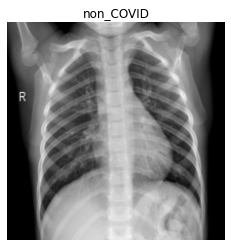

In [27]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [28]:
# Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


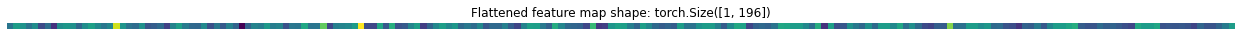

In [29]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [30]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.0184,  0.0255,  0.0140, -0.0197,  0.0080, -0.0614, -0.0261, -0.0830,
           0.0077,  0.0189,  0.0112, -0.0330,  0.0086,  0.0294,  0.0045, -0.0165,
           0.0014,  0.1246,  0.0162, -0.0202, -0.0281,  0.0108, -0.0506, -0.0440,
          -0.0301, -0.0707, -0.0031,  0.0275, -0.0112, -0.0312, -0.0329,  0.0035,
          -0.0560, -0.0170, -0.0465, -0.0053, -0.0365, -0.1218, -0.0380, -0.0037,
          -0.0092,  0.0202, -0.0091, -0.0032, -0.0554, -0.0168, -0.0187,  0.0360,
          -0.0198, -0.0176,  0.0796, -0.0658, -0.0076, -0.0018,  0.0041,  0.0235,
           0.1434, -0.0581, -0.0653,  0.0350, -0.0476,  0.0440, -0.0539, -0.0469,
          -0.0008,  0.0269, -0.0737, -0.0364,  0.0025,  0.0264,  0.0020,  0.0184,
          -0.0311, -0.0155, -0.0280,  0.0018, -0.0476, -0.0314, -0.0325, -0.0063,
          -0.0430, -0.0664, -0.0035,  0.0289,  0.0265, -0.0147, -0.0395,  0.0420,
           0.0003, -0.0309, -0.0338, -0.0386, -0.0653,  0.0576, -0.0774, -0.0718,
           0.016

In [31]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [32]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [33]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
# summary(PatchEmbedding(), 
#         input_size=random_input_image, # try swapping this for "random_input_image_error" 
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [34]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.5203,  0.1632, -0.0303,  ...,  0.3030, -0.1741,  0.0488],
         [-0.4018,  0.0891, -0.1922,  ...,  0.2979, -0.1965,  0.2532],
         [-0.3212, -0.0082, -0.1531,  ...,  0.2460, -0.0803,  0.1469],
         ...,
         [-0.6203,  0.1448, -0.2311,  ...,  0.5067, -0.3281,  0.2226],
         [-0.2293, -0.0635, -0.1352,  ...,  0.2893, -0.2007,  0.2662],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [35]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [36]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.5203,  0.1632, -0.0303,  ...,  0.3030, -0.1741,  0.0488],
         [-0.4018,  0.0891, -0.1922,  ...,  0.2979, -0.1965,  0.2532],
         ...,
         [-0.6203,  0.1448, -0.2311,  ...,  0.5067, -0.3281,  0.2226],
         [-0.2293, -0.0635, -0.1352,  ...,  0.2893, -0.2007,  0.2662],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [37]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.5203,  0.1632, -0.0303,  ...,  0.3030, -0.1741,  0.0488],
          [-0.4018,  0.0891, -0.1922,  ...,  0.2979, -0.1965,  0.2532],
          ...,
          [-0.6203,  0.1448, -0.2311,  ...,  0.5067, -0.3281,  0.2226],
          [-0.2293, -0.0635, -0.1352,  ...,  0.2893, -0.2007,  0.2662],
          [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033]]],
        grad_fn=<CatBackward0>), torch.Size([1, 197, 768]))

In [38]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1, 
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [39]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4797, 1.1632, 0.9697,  ..., 1.3030, 0.8259, 1.0488],
         [0.5982, 1.0891, 0.8078,  ..., 1.2979, 0.8035, 1.2532],
         ...,
         [0.3797, 1.1448, 0.7689,  ..., 1.5067, 0.6719, 1.2226],
         [0.7707, 0.9365, 0.8648,  ..., 1.2893, 0.7993, 1.2662],
         [0.9812, 0.9886, 0.9689,  ..., 1.0105, 0.9967, 1.0033]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [40]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


#5. Eq2: Muti-Head Attention (MSA)

In [41]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:int=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [42]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1 
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


#6. Eq3: MLP

In [43]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:int=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [44]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1 
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_mlp_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


#7. Creating the Transformer Encode

In [45]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:int=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:int=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x

In [48]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
         input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)            [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)                    [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                                [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)                   --                   [1, 197, 768]        1,771,776            True
│    │    └─NonDynamicallyQuantizableLinear (out_proj)       --                   --                   590,592              True
├─MLPBlock (mlp_block)                                       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                                [1, 197, 768]        [1, 197, 7

In [49]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

# 8. Putting it all together to Create ViT

In [50]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:int=0, # Dropout for attention projection
                 mlp_dropout:int=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:int=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_enedoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_enedoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [51]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}") 
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [52]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[0.4453, 1.0582]], grad_fn=<AddmmBackward0>)

In [54]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit, 
         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
         # col_names=["input_size"], # uncomment for smaller output
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
 )

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                              [32, 3, 224, 224]    [32, 2]              152,064              True
├─Dropout (embedding_dropout)                                          [32, 197, 768]       [32, 197, 768]       --                   --
├─PatchEmbedding (patch_embedding)                                     [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                                [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                               [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                          [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_en

# 9. Setting Up Training Code for our ViT Model

In [55]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=1e-3, # Base LR from Table 3 
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.1) # from the ViT paper section 4.1 (Training & Fine-tuning)

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8908 | train_acc: 0.6560 | test_loss: 0.6321 | test_acc: 0.6738
Epoch: 2 | train_loss: 0.6201 | train_acc: 0.7013 | test_loss: 0.6321 | test_acc: 0.6738
Epoch: 3 | train_loss: 0.6229 | train_acc: 0.6949 | test_loss: 0.6406 | test_acc: 0.6738
Epoch: 4 | train_loss: 0.6201 | train_acc: 0.6998 | test_loss: 0.6447 | test_acc: 0.6738
Epoch: 5 | train_loss: 0.6209 | train_acc: 0.6998 | test_loss: 0.6483 | test_acc: 0.6738
Epoch: 6 | train_loss: 0.6226 | train_acc: 0.7015 | test_loss: 0.6574 | test_acc: 0.6738
Epoch: 7 | train_loss: 0.6253 | train_acc: 0.7004 | test_loss: 0.6806 | test_acc: 0.6738
Epoch: 8 | train_loss: 0.6180 | train_acc: 0.7004 | test_loss: 0.6317 | test_acc: 0.6738
Epoch: 9 | train_loss: 0.6137 | train_acc: 0.6999 | test_loss: 0.6439 | test_acc: 0.6738
Epoch: 10 | train_loss: 0.6151 | train_acc: 0.6999 | test_loss: 0.6372 | test_acc: 0.6738


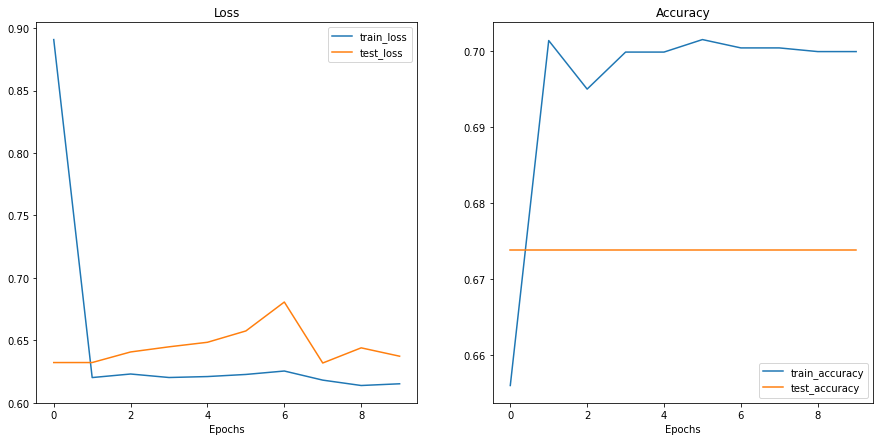

In [56]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

#10. Using pretrained ViT from torchvision.models

In [57]:
# The following requires torch v0.12+ and torchvision v0.13+
import torch
import torchvision
print(torch.__version__) 
print(torchvision.__version__)

1.12.1+cu113
0.13.1+cu113


In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [59]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [61]:
# # Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
         # col_names=["input_size"], # uncomment for smaller output
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
 )

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                                  [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                                   [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                                    [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                               [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                             [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                             [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─Encod

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
from pathlib import Path

# Setup path to data folder
data_path = Path("/content/drive/My Drive/Data/XRay")
image_path = data_path / "XRayExtract"
walk_through_dir(image_path)

There are 2 directories and 0 images in '/content/drive/My Drive/Data/XRay/XRayExtract'.
There are 2 directories and 0 images in '/content/drive/My Drive/Data/XRay/XRayExtract/Test'.
There are 0 directories and 167 images in '/content/drive/My Drive/Data/XRay/XRayExtract/Test/COVID'.
There are 0 directories and 317 images in '/content/drive/My Drive/Data/XRay/XRayExtract/Test/non_COVID'.
There are 2 directories and 0 images in '/content/drive/My Drive/Data/XRay/XRayExtract/Train'.
There are 0 directories and 543 images in '/content/drive/My Drive/Data/XRay/XRayExtract/Train/COVID'.
There are 0 directories and 1266 images in '/content/drive/My Drive/Data/XRay/XRayExtract/Train/non_COVID'.


In [67]:
from helper_functions import download_data

data_path = Path("/content/drive/My Drive/Data/XRay")
image_path = data_path / "XRayExtract"


In [72]:
# Setup train and test directory paths
train_dir = image_path / "Train"
test_dir = image_path / "Test" 
train_dir, test_dir

(PosixPath('/content/drive/My Drive/Data/XRay/XRayExtract/Train'),
 PosixPath('/content/drive/My Drive/Data/XRay/XRayExtract/Test'))

In [69]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [73]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [74]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1756 | train_acc: 0.9217 | test_loss: 0.0730 | test_acc: 0.9844
Epoch: 2 | train_loss: 0.0501 | train_acc: 0.9863 | test_loss: 0.0510 | test_acc: 0.9883
Epoch: 3 | train_loss: 0.0379 | train_acc: 0.9902 | test_loss: 0.0404 | test_acc: 0.9922
Epoch: 4 | train_loss: 0.0307 | train_acc: 0.9918 | test_loss: 0.0354 | test_acc: 0.9922
Epoch: 5 | train_loss: 0.0273 | train_acc: 0.9929 | test_loss: 0.0309 | test_acc: 0.9922
Epoch: 6 | train_loss: 0.0245 | train_acc: 0.9951 | test_loss: 0.0266 | test_acc: 0.9941
Epoch: 7 | train_loss: 0.0195 | train_acc: 0.9967 | test_loss: 0.0249 | test_acc: 0.9941
Epoch: 8 | train_loss: 0.0169 | train_acc: 0.9978 | test_loss: 0.0234 | test_acc: 0.9922
Epoch: 9 | train_loss: 0.0157 | train_acc: 0.9973 | test_loss: 0.0226 | test_acc: 0.9922
Epoch: 10 | train_loss: 0.0141 | train_acc: 0.9978 | test_loss: 0.0212 | test_acc: 0.9941


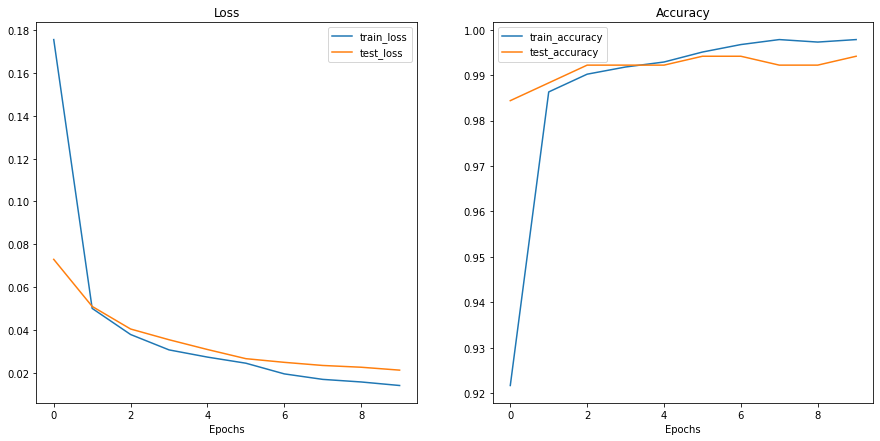

In [75]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [76]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="ViT_XRay_Covid_nonCovid.pth")

[INFO] Saving model to: models/ViT_XRay_Covid_nonCovid.pth


In [79]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/ViT_XRay_Covid_nonCovid.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


# 11. Making predictions on a Custom Image

In [86]:
from torchvision import io
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    mode = io.image.ImageReadMode.RGB
    target_image = torchvision.io.read_image(str(image_path),mode).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

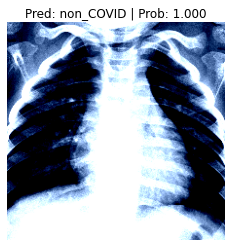

In [100]:
import requests

# Import function to make predictions on images and plot them 


# setup custom image path

#custom_image_path2 = '/content/drive/My Drive/Data/CustomImageTest/NORMAL(110).jpg'
#custom_image_path2 = '/content/drive/My Drive/Data/CustomImageTest/NORMAL(143).jpg'
custom_image_path2 = '/content/drive/My Drive/Data/CustomImageTest/NORMAL(155).jpg'
#custom_image_path2 = '/content/drive/My Drive/Data/CustomImageTest/COVID-19 (353).jpg'
#custom_image_path2 = '/content/drive/My Drive/Data/CustomImageTest/COVID-19 (439).jpg'
#custom_image_path2 = '/content/drive/My Drive/Data/CustomImageTest/COVID-19 (609).jpg'



pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path2,
                    class_names=class_names,
                    transform=pretrained_vit_transforms)
                    